# Nicaragua project

#### Importing libraries to plot the map

In [1]:
import folium
from geopy.geocoders import Nominatim

In [2]:
address = 'Nicaragua'

geolocator = Nominatim(user_agent="ni_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Nicaragua are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Nicaragua are 12.6090157, -85.2936911.


In [3]:
map_nicaragua = folium.Map(location=[latitude, longitude], zoom_start=7)

map_nicaragua

#### Importing libraries

In [4]:
import pandas as pd
import requests, six
import json
from pandas.io.json import json_normalize
import numpy as np

In [5]:
df = pd.read_excel('geo_nic.xlsx')
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Managua,Managua,12.13282,-86.25040
1,Managua,Ticuantepe,12.02263,-86.20493
2,Managua,San Rafael del Sur,11.84854,-86.43839
3,Managua,El Crucero,11.99008,-86.30954
4,Managua,Tipitapa,12.19732,-86.09706


In [6]:
df.shape

(139, 4)

In [7]:
df.dtypes

Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

#### Plot the map with Nicaragua's neighborhood

In [8]:
# create map of Nicaragua using latitude and longitude values
map_nicaragua = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nicaragua)  
    
map_nicaragua

#### Foursquare credentials

In [9]:
CLIENT_ID = 'MM4ZIROIAHCFG5BFIULIHOJMLSP0CD1RC3RAMXB3EGEDH3B2' # your Foursquare ID
CLIENT_SECRET = '0AMO4V411YCS0KNCGBVEKIIFQC0PZ5GUWOG1GWTJ5SKB5PCN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MM4ZIROIAHCFG5BFIULIHOJMLSP0CD1RC3RAMXB3EGEDH3B2
CLIENT_SECRET:0AMO4V411YCS0KNCGBVEKIIFQC0PZ5GUWOG1GWTJ5SKB5PCN


In [10]:
df.loc[4, 'Neighborhood']

'Tipitapa'

In [11]:
neighborhood_latitude = df.loc[4, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[4, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[4, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Tipitapa are 12.19732, -86.09706.


In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=MM4ZIROIAHCFG5BFIULIHOJMLSP0CD1RC3RAMXB3EGEDH3B2&client_secret=0AMO4V411YCS0KNCGBVEKIIFQC0PZ5GUWOG1GWTJ5SKB5PCN&v=20180605&ll=12.19732,-86.09706&radius=5000&limit=100'

In [13]:
results = requests.get(url).json()

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\mjmad\Anaconda3\envs\gmtalentoso3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Termales Tipitapa,Hot Spring,12.202835,-86.091691
1,Sopas Mirna,Soup Place,12.191147,-86.100832
2,Farmacia Xolotlan- Tipitapa,Pharmacy,12.195813,-86.096097
3,Asados Guadalupe,BBQ Joint,12.197969,-86.094788
4,Pollo Estrella,Fried Chicken Joint,12.201215,-86.097057


In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

6 venues were returned by Foursquare.


In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
nicaragua_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Managua
Ticuantepe
San Rafael del Sur
El Crucero
Tipitapa
Ciudad Sandino
Mateare
San Francisco Libre
Dolores
Diriamba
La Paz
San Marcos
El Rosario
Jinotepe
La Conquista
Santa Teresa
El Sauce
La Paz Centro
Nagarote
Achuapa
El Jicaral
El Sauce
Leon
Larreynaga
Quezalguaque
Telica
El Viejo
Somotillo
Chichigalpa
Corinto
El Realejo
Chinandega
Posoltega
Puerto Morazán
San Francisco del Norte
San Juan de Cinco Pinos
San Pedro del Norte
Santo Tomás del Norte
Altagracia
Tola
San Juan del Sur
Belén
Buenos Aires
Cárdenas
Moyogalpa
Potosí
San Jorge
Rivas
La Concepcion
Catarina
Masatepe
Nandasmo
Nindirí
Niquinohomo
San Juan de Oriente
Tisma
Masaya
Diriá
Granada
Diriomo
Nandaime
La Trinidad
Condega
Pueblo Nuevo
San Juan de Limay
Esteli
Somoto
Las Sabanas
Palacagüina
Telpaneca
Totogalpa
San Lucas
Yalagüina
Ocotal
Ciudad Antigua
Dipilto
Jalapa
Macuelizo
Mozonte
Murra
Quilalí
San Fernando
San José de los Remates
San Lorenzo
Camoapa
Boaco
San Lorenzo
Santa Lucía
Teustepe
Comalapa
El Coral
Acoyapa
La Libe

#### Dataframe with all venues

In [19]:
print(nicaragua_venues.shape)
nicaragua_venues.head()

(579, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Managua,12.13282,-86.2504,Coffee And Honey Shop De La Finca,12.133886,-86.246710,Breakfast Spot
1,Managua,12.13282,-86.2504,Taquería La Pancha,12.135828,-86.249416,Mexican Restaurant
2,Managua,12.13282,-86.2504,Hospital Animal: Dr. Jorge Diaz,12.135123,-86.249991,Pet Store
3,Managua,12.13282,-86.2504,D' Mi Vaquita Cafe,12.131865,-86.246025,Breakfast Spot
4,Managua,12.13282,-86.2504,Restaurante Oriental,12.136771,-86.250856,Chinese Restaurant


In [20]:
nicaragua_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acoyapa,2,2,2,2,2,2
Altagracia,4,4,4,4,4,4
Belén,3,3,3,3,3,3
Bluefields,6,6,6,6,6,6
Boaco,7,7,7,7,7,7
...,...,...,...,...,...,...
Ticuantepe,5,5,5,5,5,5
Tipitapa,4,4,4,4,4,4
Tola,3,3,3,3,3,3


In [21]:
print('There are {} uniques categories.'.format(len(nicaragua_venues['Venue Category'].unique())))

There are 124 uniques categories.


In [22]:
# one hot encoding
nicaragua_onehot = pd.get_dummies(nicaragua_venues[['Venue Category']], prefix="", prefix_sep="")
nicaragua_onehot.head()

,ATM,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bakery,...,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Theme Park,Theme Park Ride / Attraction,Travel & Transport,Vegetarian / Vegan Restaurant,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
nicaragua_onehot.insert(0, 'Neighborhood', nicaragua_venues['Neighborhood'])
nicaragua_onehot.head()

,Neighborhood,ATM,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,...,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Theme Park,Theme Park Ride / Attraction,Travel & Transport,Vegetarian / Vegan Restaurant,Wings Joint,Yoga Studio
0,Managua,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Managua,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Managua,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Managua,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Managua,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Dataframe to cluster neighborhood

In [24]:
nicaragua_grouped = nicaragua_onehot.groupby('Neighborhood').mean().reset_index()
nicaragua_grouped

,Neighborhood,ATM,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,...,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Theme Park,Theme Park Ride / Attraction,Travel & Transport,Vegetarian / Vegan Restaurant,Wings Joint,Yoga Studio
0,Acoyapa,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Altagracia,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Belén,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bluefields,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Boaco,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Ticuantepe,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,Tipitapa,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,Tola,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,Villa Sandino,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Elbow Method

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [26]:
df_elbow = nicaragua_grouped.drop('Neighborhood', 1)
df_elbow.head()

,ATM,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bakery,...,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Theme Park,Theme Park Ride / Attraction,Travel & Transport,Vegetarian / Vegan Restaurant,Wings Joint,Yoga Studio
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


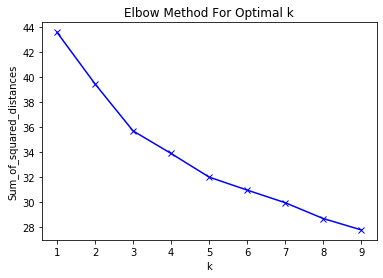

In [27]:
Sum_of_squared_distances = []
K = range(1, 10)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(df_elbow)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

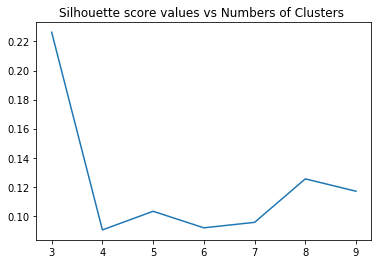

Optimal number of components is:
3


In [28]:
import numpy as numpy
import sklearn
 
obs = df_elbow.copy() 
# obs = numpy.concatenate( (numpy.random.randn(100, 2) , 20 + numpy.random.randn(300, 2) , -15+numpy.random.randn(200, 2)))
silhouette_score_values=list()
 
NumberOfClusters=range(3,10)
 
for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=10)
    classifier.fit(obs)
    labels= classifier.predict(obs)
#     print("Number Of Clusters:")
#     print(i)
#     print("Silhouette score value")
#     print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', random_state=0))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Most common venues in each neighborhood

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nicaragua_grouped['Neighborhood']

for ind in np.arange(nicaragua_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nicaragua_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acoyapa,Restaurant,Bar,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall
1,Altagracia,Hotel,Park,Motel,Yoga Studio,Donut Shop,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall
2,Belén,BBQ Joint,Park,Bar,Yoga Studio,Dive Bar,Diner,Dessert Shop,Department Store,Cuban Restaurant,Convenience Store
3,Bluefields,Pier,Park,Cafeteria,Fried Chicken Joint,Mexican Restaurant,Seafood Restaurant,Convenience Store,Dessert Shop,Department Store,Cuban Restaurant
4,Boaco,ATM,Park,Latin American Restaurant,Food & Drink Shop,Bus Station,Café,Pizza Place,Coffee Shop,Comfort Food Restaurant,Diner


In [31]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood'] == 'Acoyapa']

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acoyapa,Restaurant,Bar,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall


## Clustering

In [32]:
from sklearn.cluster import KMeans

In [33]:
# set number of clusters
kclusters = 3

nicaragua_grouped_clustering = nicaragua_grouped.drop('Neighborhood', 1)
nicaragua_grouped_clustering.head()

,ATM,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bakery,...,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Theme Park,Theme Park Ride / Attraction,Travel & Transport,Vegetarian / Vegan Restaurant,Wings Joint,Yoga Studio
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nicaragua_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nicaragua_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nicaragua_merged = nicaragua_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nicaragua_merged.tail() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
134,RCCS,Corn Island,12.17575,-83.06145,0.0,Airport,Pier,Hotel,Yoga Studio,Convenience Store,Dive Bar,Diner,Dessert Shop,Department Store,Cuban Restaurant
135,RCCS,El Ayote,12.19046,-85.28737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,RCCS,El Tortuguero,12.82247,-84.19269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,RCCS,Kukra Hill,12.24096,-83.74517,0.0,Restaurant,Bar,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall
138,RCCS,Muelle de los Bueyes,12.06999,-84.53503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
missing_data = nicaragua_merged.isnull() #Devuelve true si el dato falta
missing_data.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [37]:
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

Borough
False    139
Name: Borough, dtype: int64

Neighborhood
False    139
Name: Neighborhood, dtype: int64

Latitude
False    139
Name: Latitude, dtype: int64

Longitude
False    139
Name: Longitude, dtype: int64

Cluster Labels
False    101
True      38
Name: Cluster Labels, dtype: int64

1st Most Common Venue
False    101
True      38
Name: 1st Most Common Venue, dtype: int64

2nd Most Common Venue
False    101
True      38
Name: 2nd Most Common Venue, dtype: int64

3rd Most Common Venue
False    101
True      38
Name: 3rd Most Common Venue, dtype: int64

4th Most Common Venue
False    101
True      38
Name: 4th Most Common Venue, dtype: int64

5th Most Common Venue
False    101
True      38
Name: 5th Most Common Venue, dtype: int64

6th Most Common Venue
False    101
True      38
Name: 6th Most Common Venue, dtype: int64

7th Most Common Venue
False    101
True      38
Name: 7th Most Common Venue, dtype: int64

8th Most Common Venue
False    101
True      38
Name: 8th Most Common 

In [38]:
nicaragua_merged.dropna(subset=['Cluster Labels'], axis=0, inplace=True)
nicaragua_merged.shape

(101, 15)

In [39]:
nicaragua_merged = nicaragua_merged.astype({'Cluster Labels': 'int64'})

## Plot map with different cluster

In [40]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nicaragua_merged['Latitude'], nicaragua_merged['Longitude'], nicaragua_merged['Neighborhood'], nicaragua_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Cluster 1

In [42]:
nicaragua_merged.loc[nicaragua_merged['Cluster Labels'] == 0, nicaragua_merged.columns[[1] + list(range(5, nicaragua_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Managua,Breakfast Spot,Mexican Restaurant,Pet Store,Chinese Restaurant,Big Box Store,Hotel,Sports Bar,Snack Place,Department Store,Diner
1,Ticuantepe,Caribbean Restaurant,BBQ Joint,Clothing Store,Market,Bar,Dive Bar,Diner,Dessert Shop,Department Store,Cuban Restaurant
2,San Rafael del Sur,Soccer Stadium,Ice Cream Shop,Mobile Phone Shop,Snack Place,Market,Pizza Place,Forest,Food Service,Chinese Restaurant,Church
3,El Crucero,City,Restaurant,Coffee Shop,Yoga Studio,Donut Shop,Church,Clothing Store,Comfort Food Restaurant,Concert Hall,Convenience Store
4,Tipitapa,Seafood Restaurant,Fruit & Vegetable Store,Restaurant,BBQ Joint,Yoga Studio,Concert Hall,Dessert Shop,Department Store,Cuban Restaurant,Convenience Store
...,...,...,...,...,...,...,...,...,...,...,...
131,El Rama,Boat or Ferry,Hotel,Seafood Restaurant,Bus Station,Cafeteria,Pharmacy,Furniture / Home Store,Park,Clothing Store,Coffee Shop
132,Nueva Guinea,Restaurant,Seafood Restaurant,Latin American Restaurant,Yoga Studio,Dive Bar,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant
133,Laguna de Perlas,Hotel,Caribbean Restaurant,Pier,Beach,Cuban Restaurant,Dive Bar,Diner,Dessert Shop,Department Store,Concert Hall
134,Corn Island,Airport,Pier,Hotel,Yoga Studio,Convenience Store,Dive Bar,Diner,Dessert Shop,Department Store,Cuban Restaurant


In [46]:
cluster1 = nicaragua_merged.loc[nicaragua_merged['Cluster Labels'] == 0, nicaragua_merged.columns[[1] + list(range(5, nicaragua_merged.shape[1]))]]
cluster1.shape

(89, 11)

# Cluster 2 

In [43]:
nicaragua_merged.loc[nicaragua_merged['Cluster Labels'] == 1, nicaragua_merged.columns[[1] + list(range(5, nicaragua_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Nagarote,Park,Restaurant,Yoga Studio,Caribbean Restaurant,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall
24,Quezalguaque,Park,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store
28,Chichigalpa,Grocery Store,Park,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store
30,El Realejo,Park,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store
87,Santa Lucía,Park,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store
111,San Dionisio,Park,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store


In [47]:
cluster2 = nicaragua_merged.loc[nicaragua_merged['Cluster Labels'] == 1, nicaragua_merged.columns[[1] + list(range(5, nicaragua_merged.shape[1]))]]
cluster2.shape

(6, 11)

In [44]:
# Cluster 3

In [45]:
nicaragua_merged.loc[nicaragua_merged['Cluster Labels'] == 2, nicaragua_merged.columns[[1] + list(range(5, nicaragua_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,Telpaneca,Mountain,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store
79,Murra,Mountain,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store
80,Quilalí,Hotel,Mountain,Yoga Studio,Drugstore,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store
103,Santa María de Pantasma,Pet Store,Mountain,Yoga Studio,Donut Shop,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store
113,La Dalia,Mountain,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store
122,Bonanza,Mountain,Yoga Studio,Donut Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store


In [48]:
cluster3 = nicaragua_merged.loc[nicaragua_merged['Cluster Labels'] == 2, nicaragua_merged.columns[[1] + list(range(5, nicaragua_merged.shape[1]))]]
cluster3.shape

(6, 11)

# Thanks!